In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import innvestigate

from keras.models import load_model
from keras import backend as K
from keras.utils import Sequence

from utils import load_nifti, normalize_float, IntensityRescale
from config import *

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "5"
set_session(tf.Session(config=config))

In [3]:
zero_one_normalize = True
dtype = np.float32
z_factor = 0.525
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions"

In [4]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_FLAIR_lesions_filled.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_FLAIR_lesions_filled.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

train_lesions_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_lesions.h5', 'r')
holdout_lesions_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_lesions.h5', 'r')

lesion_masks_train = train_lesions_h5['masks']
lesion_masks_holdout = holdout_lesions_h5['masks']

In [5]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [6]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

## Make dataset

In [7]:
intensity = IntensityRescale(masked=False)

In [8]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


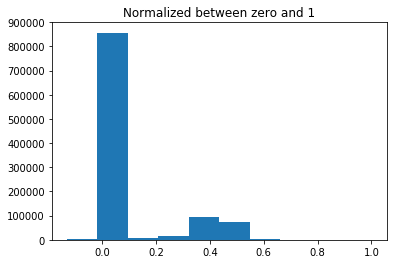

In [9]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


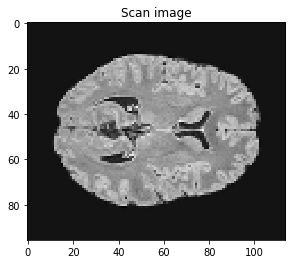

In [10]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

# Model

In [11]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [12]:
# load model weights
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_7.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [13]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [14]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [15]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0022606917191296816


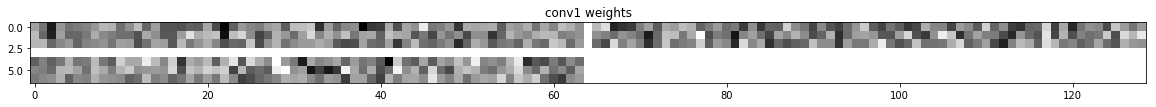

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0001428466639481485


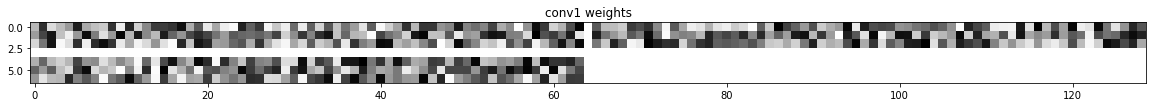

In [16]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

# Visualization

In [33]:
def plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis):
    r = 2
    c = 2
    # Displaying the gradient
    plt.figure(figsize=(14,12))
    plt.subplots_adjust(hspace=0.15, wspace=0.)
    ax1 = plt.subplot(r, c, 1)
    plt.imshow(X_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Scan")
    ax2 = plt.subplot(r, c, 2)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Lesion mask")
    ax3 = plt.subplot(r, c, 3)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='Reds', alpha=0.6, vmin=0.1)
    plt.title("Lesion mask over scan")
    ax4 = plt.subplot(r, c, 4)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(analysis.squeeze()[:,:,sl], cmap='Reds', interpolation='nearest', alpha=0.6)
    plt.title("Heatmap overlayed")
    plt.show()

In [34]:
num_trials = 10
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [35]:
import keras.layers
import keras.models
import keras.utils

import innvestigate.utils as iutils

In [52]:
model = load_model(model_path)
#model_dir = os.path.join(result_dir, weights[2]) # select best model
model_dir = os.path.join(result_dir, weights[1]) # select other model
model.load_weights(model_dir)

In [63]:
image_idx = 6
sl = 48
b = 1
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=b, shuffle=False, z_factor=z_factor)
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [64]:
print(label)

[1]


In [65]:
image.shape

(1, 96, 114, 96, 1)

In [66]:
pred = model.predict(image)
print("Model prediction: {} with final sigmoid output: {:.4f}".format((pred.item()>=0.5)*1, pred.item()))

Model prediction: 1 with final sigmoid output: 0.9749


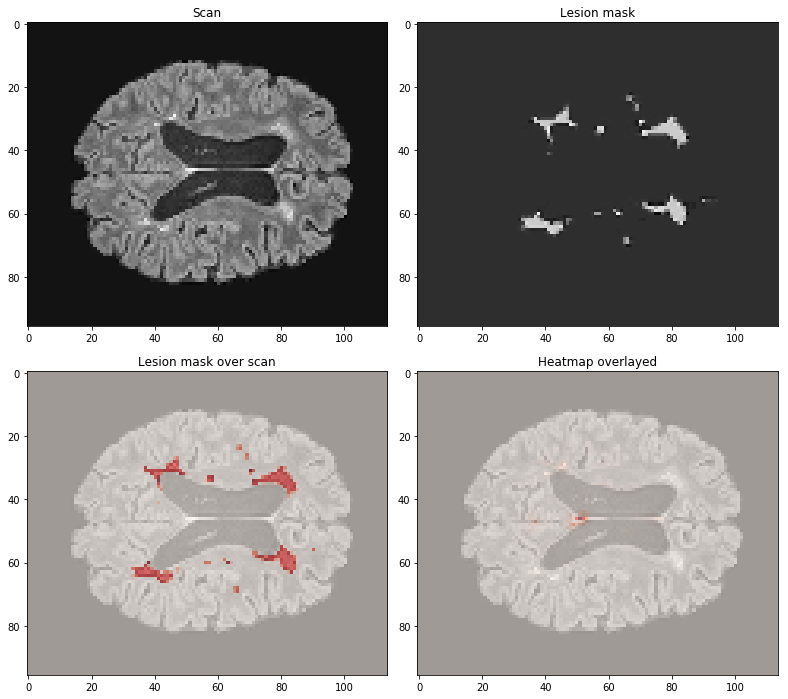

In [67]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

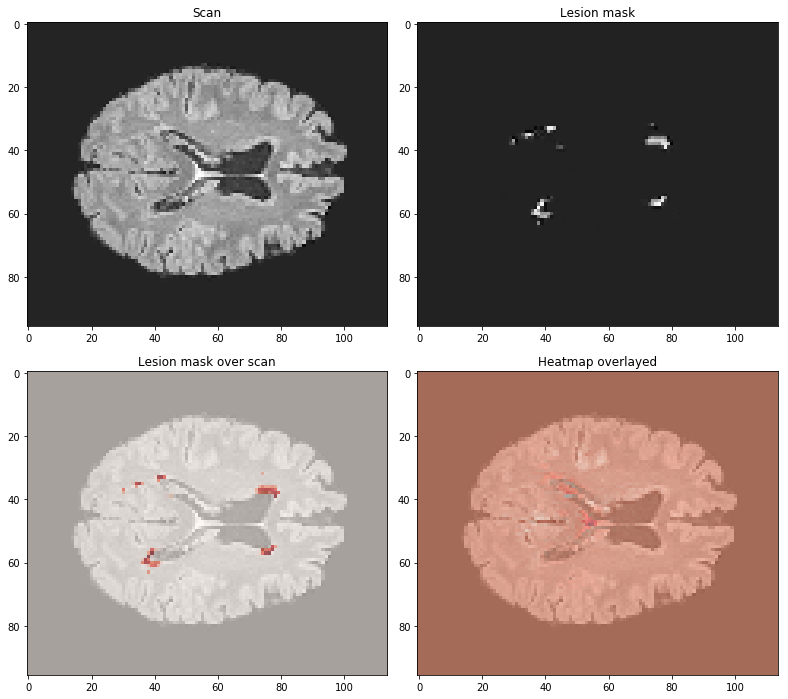

In [42]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

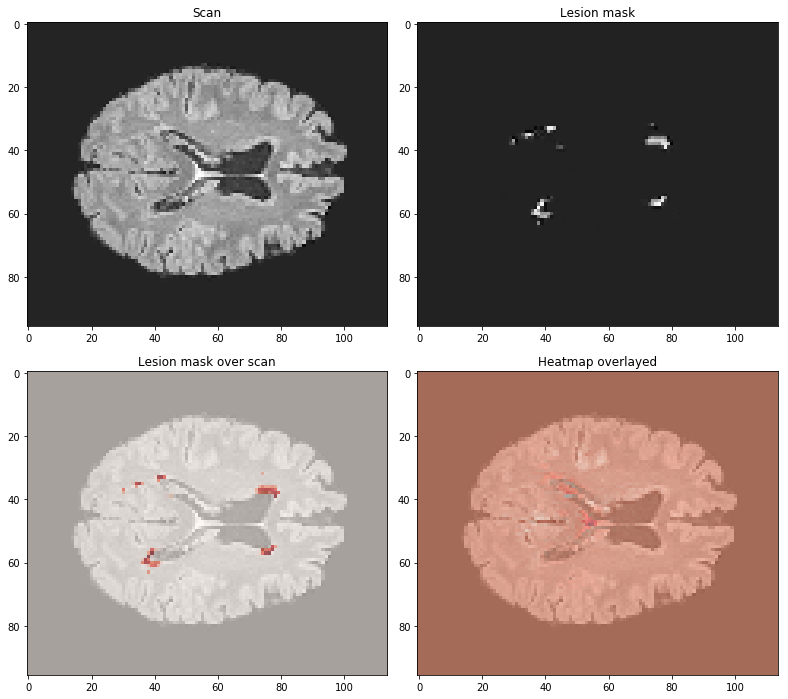

In [43]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

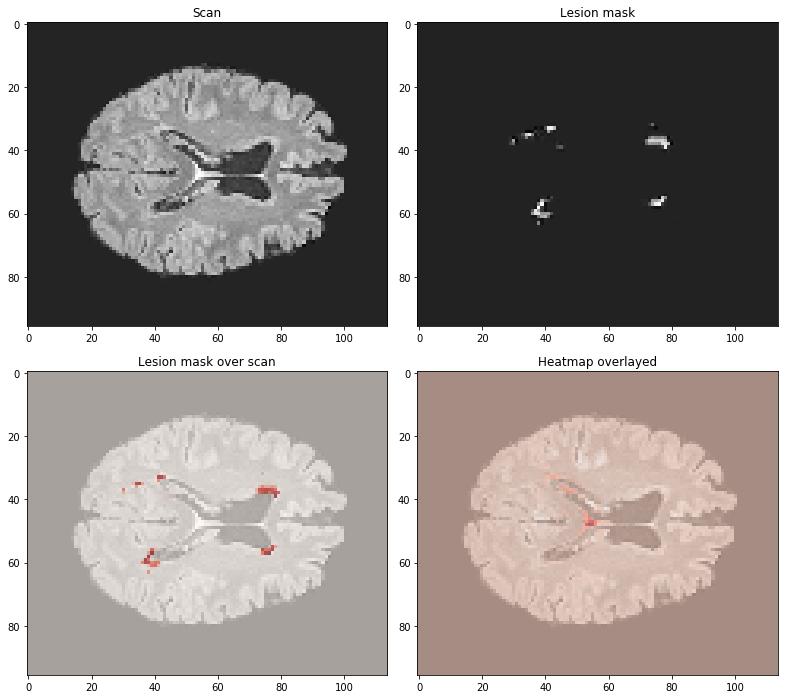

In [44]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

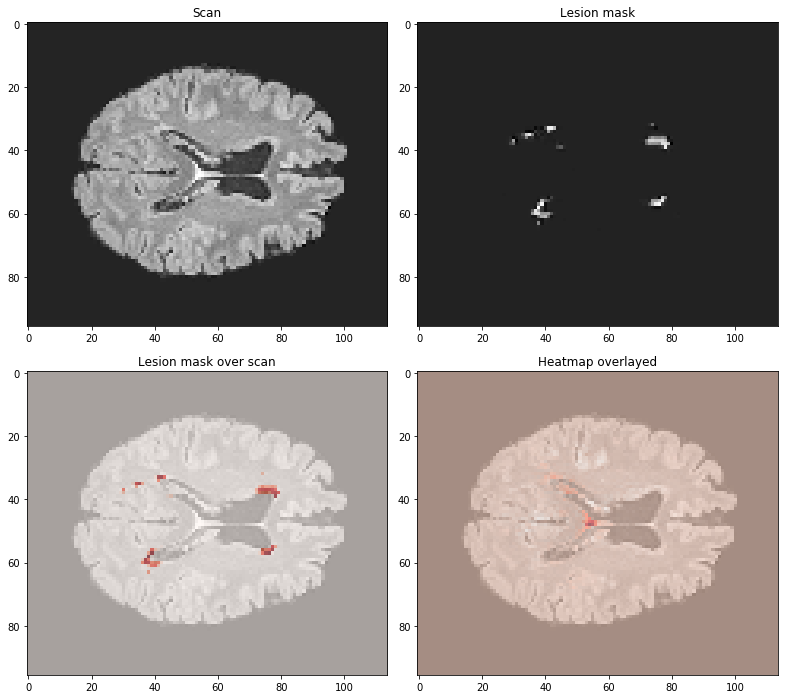

In [45]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

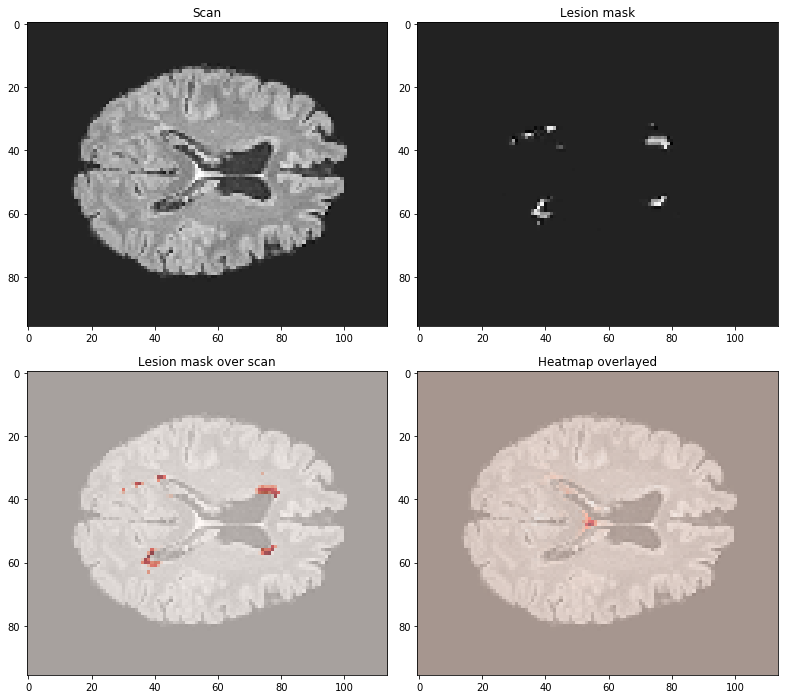

In [46]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

## Using only the pre-trained model / no fine-tuning

In [30]:
# loading pre-trained model
model = load_model(model_path)

In [31]:
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [32]:
print(label)

[1]


In [33]:
pred = model.predict(image)
print("Model prediction: {} with final simgoid output: {:.4f}".format((pred.item()>=0.5)*1, pred.item()))

Model prediction: 0 with final simgoid output: 0.4851


In [34]:
image.shape

(1, 96, 114, 96, 1)

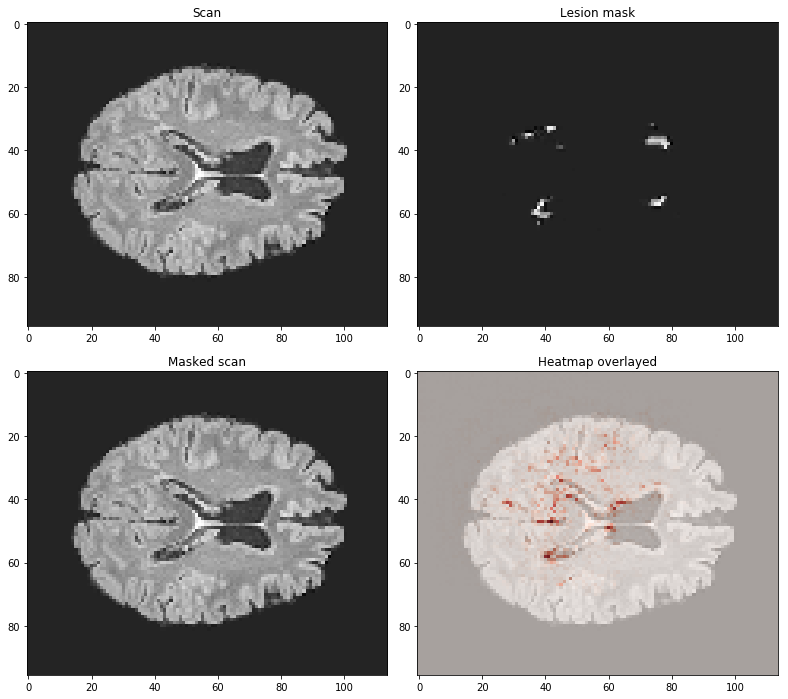

In [35]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

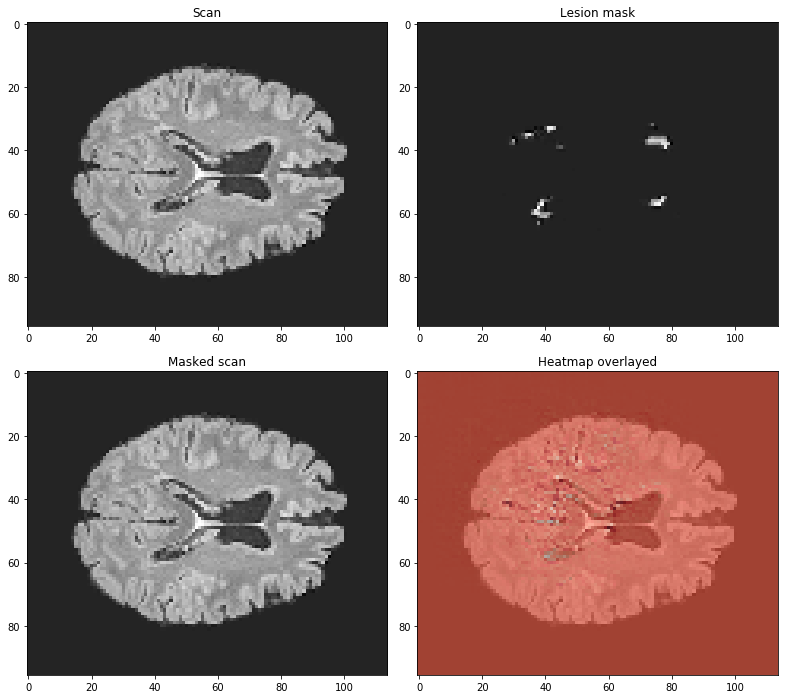

In [36]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

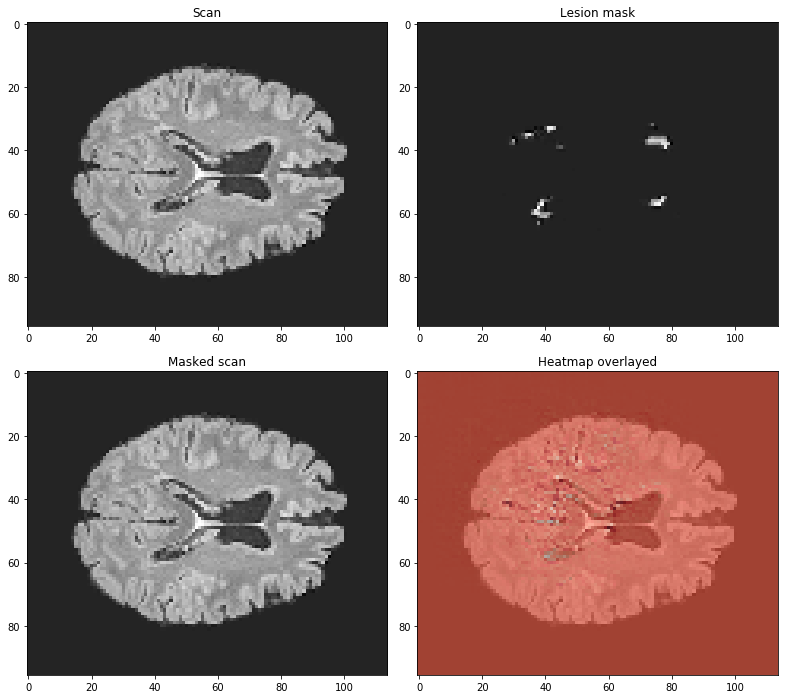

In [37]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

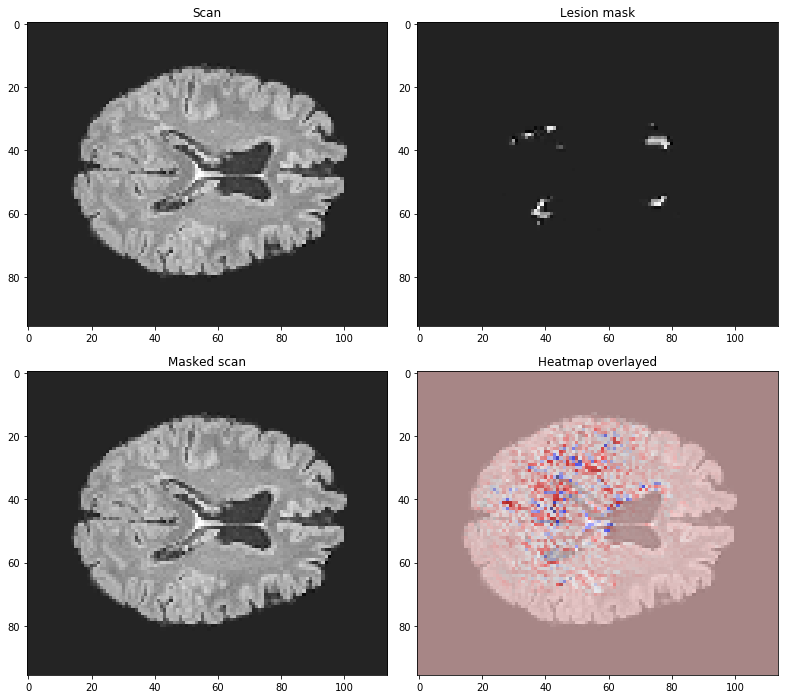

In [38]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

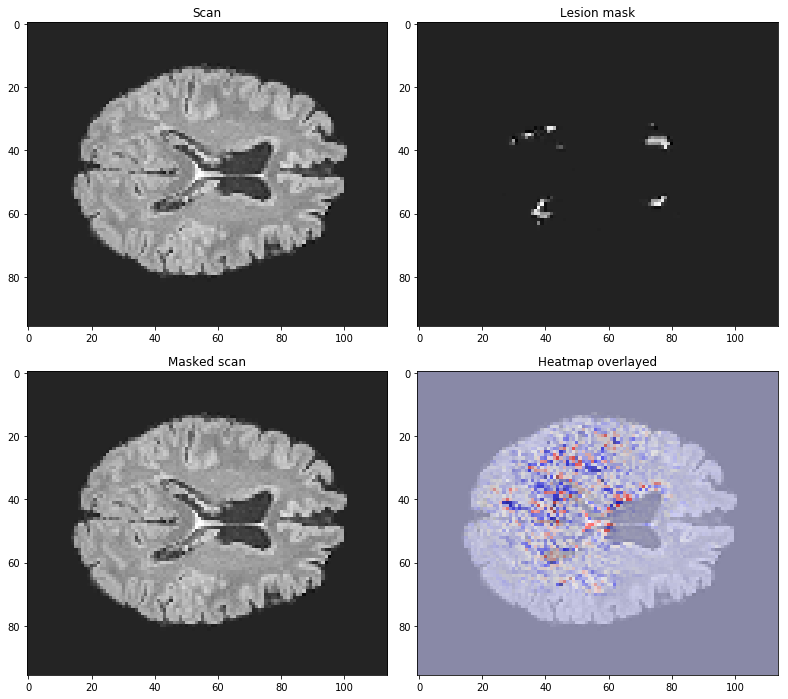

In [39]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

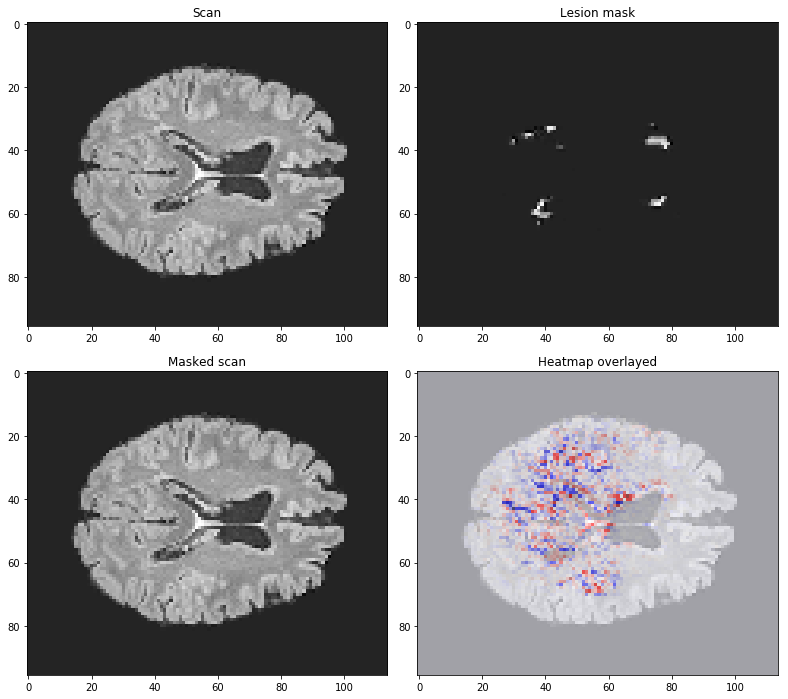

In [40]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

## Random weights

In [41]:
# use random weights
model = load_model(model_path)
reset_weights(model)

In [42]:
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [43]:
print(label)

[1]


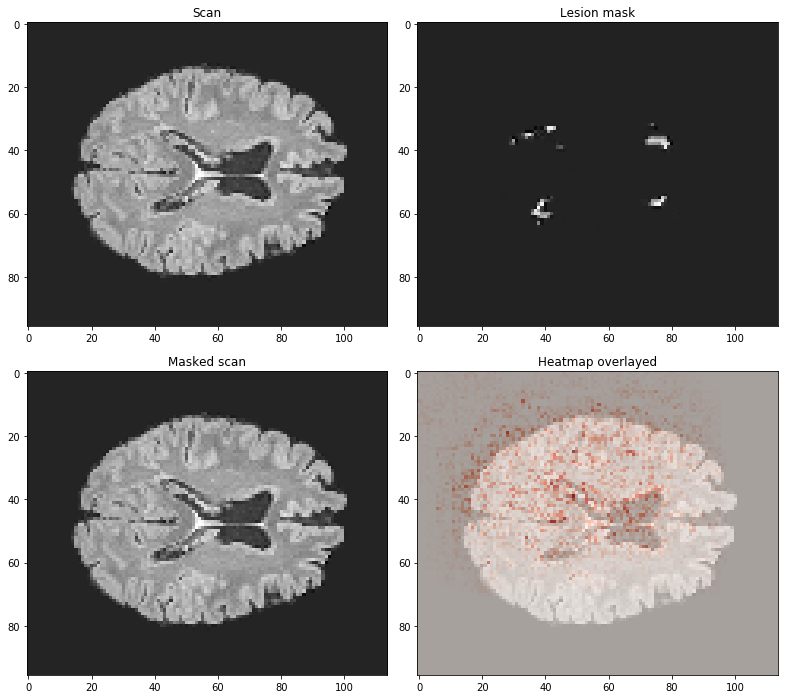

In [44]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

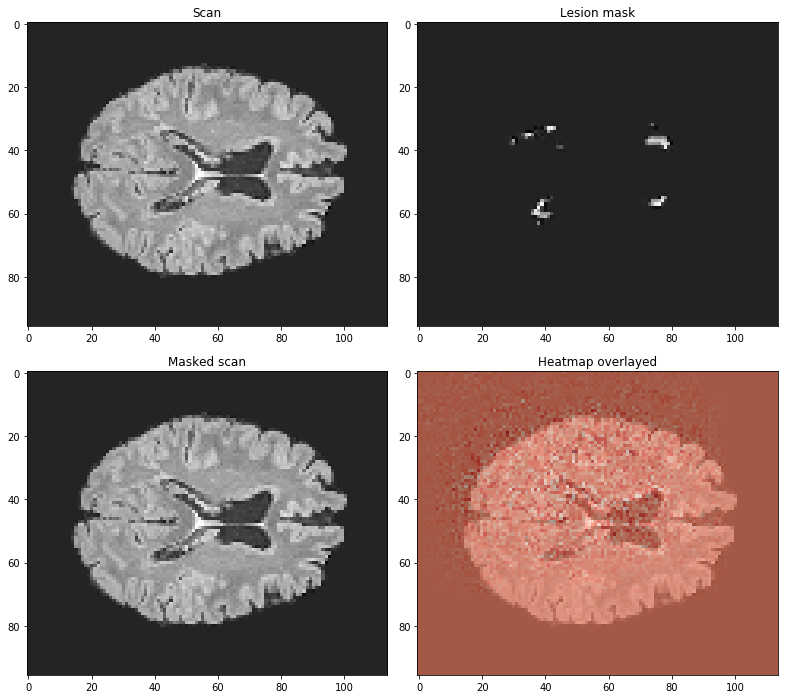

In [45]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

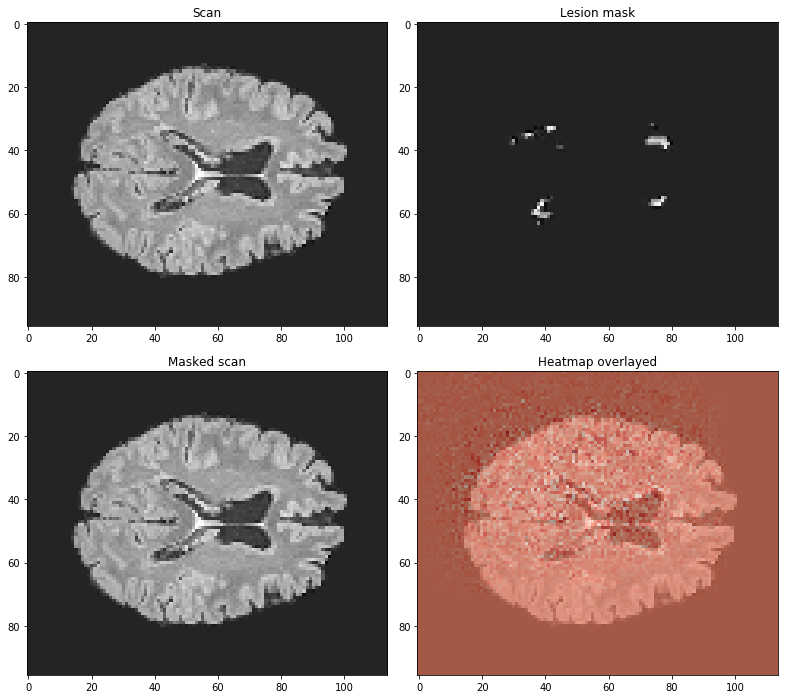

In [46]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

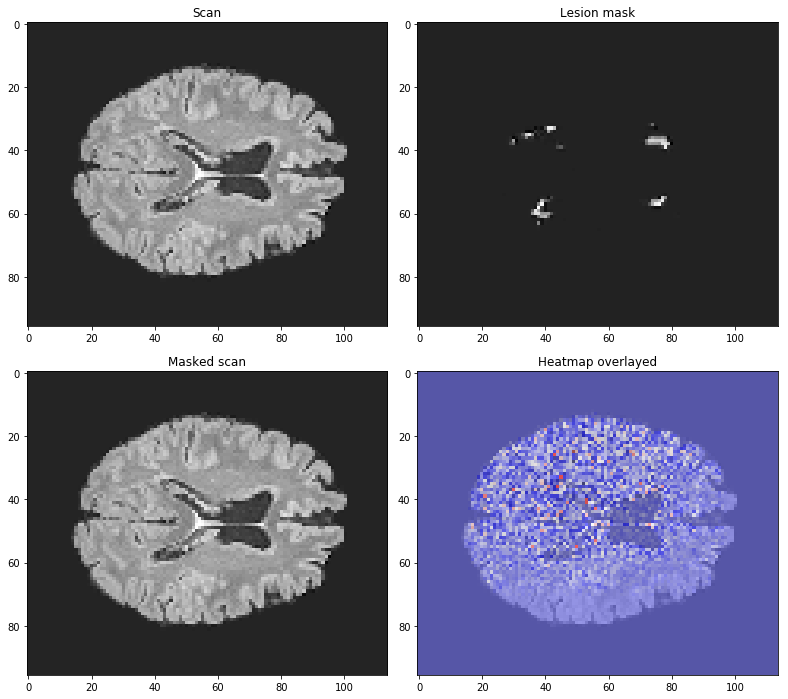

In [47]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

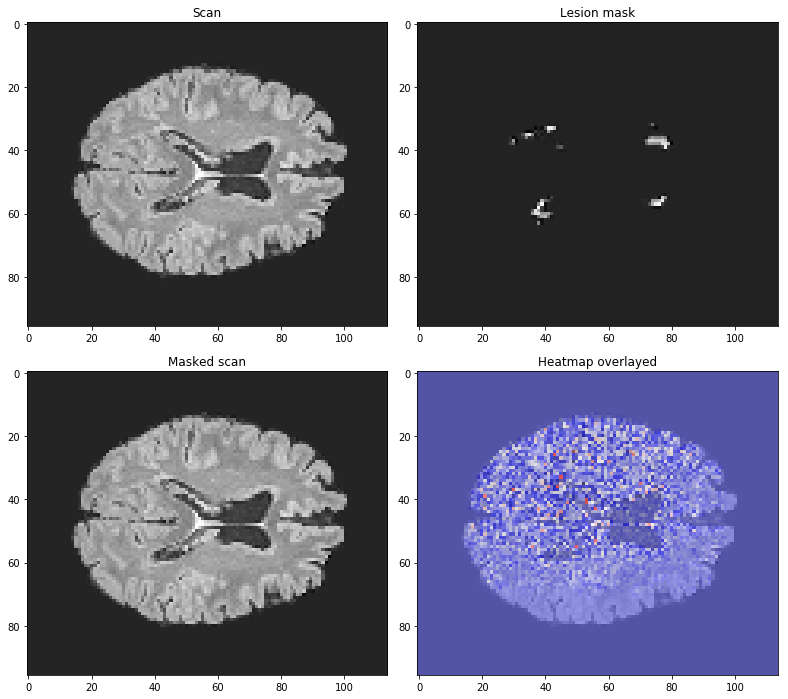

In [48]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

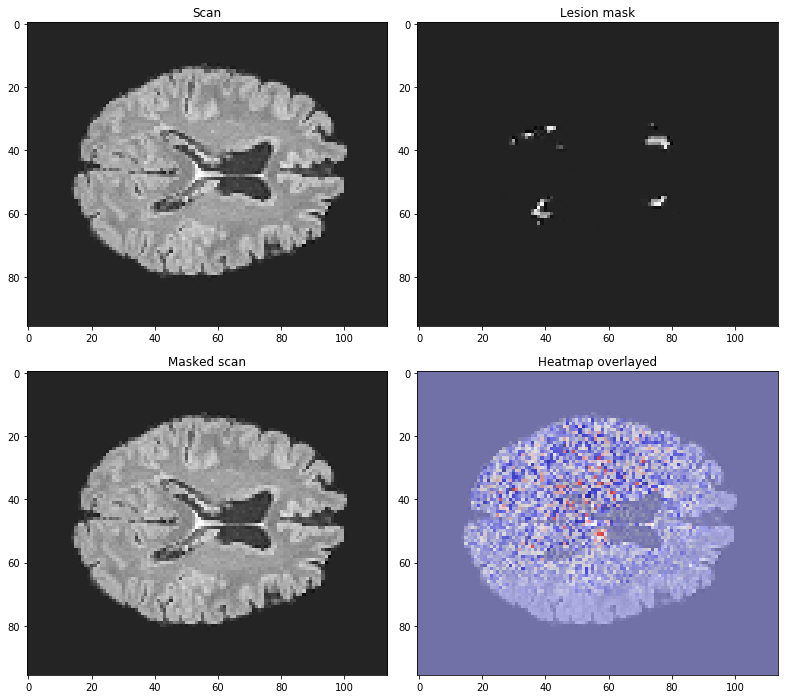

In [49]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [50]:
#quit()